In [103]:
import os
import sys
import itertools

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

if '..' not in sys.path: sys.path.insert(0, '..')
from common import colors
import splines

In [111]:
import numpy as np
import matplotlib.pyplot as plt
data = np.array([
    [0, 9],
    [1, 6],
    [2, 5],
    [3, 20],
    [4, 10],
    [5, 20],
    [6, 30],
    [7, 42],
    [8, 24],
    [9, 32],
    [10, 45],

])

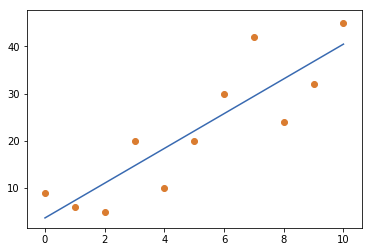

In [112]:
m = len(data)
X = np.array([np.ones(m), data[:, 0]]).T
y = np.array(data[:, 1]).reshape(-1, 1)
betaHat = np.linalg.solve(X.T.dot(X), X.T.dot(y))
plt.figure(1)
xx = np.linspace(0, 10, 5)
yy = np.array(betaHat[0] + betaHat[1] * xx)
plt.plot(xx, yy.T, color=colors.line_indexed[0])
plt.scatter(data[:, 0], data[:, 1], color=colors.line_indexed[1])
plt.show()


In [113]:
def b_spline_A(order, cp_size, data_size):
    assert(order <= cp_size)
    m = data_size
    n = cp_size
    knots = splines.uniform_knots(n, order)
    knot_range = ((knots[-1]-0.01) - knots[0])

    rows = []
    for u in range(m):
        u = u / float(m-1)
        t = (u * knot_range) + knots[0]
        rows.append([splines.N(i, order-1, t, knots) for i in range(n)])
    A = np.array(rows)
    return A

In [128]:
def find_b_spline(order, control_points_size):
    m = len(data)
    X = b_spline_A(order, control_points_size, m)
    y = np.array(data[:, 1]).reshape(-1, 1)
    betaHat = np.linalg.solve(X.T.dot(X), X.T.dot(y))
    x_min = data[0][0]
    x_max = data[-1][0]
    x_range = x_max - x_min
    y_values = betaHat[:, 0]
    step = x_range / (len(y_values)-1)
    cur = 0.0
    x_values = []
    for x in range(len(y_values)):
        x_values.append(cur)
        cur += step
    control_points = np.array(list(zip(x_values, y_values)))
    xx = np.linspace(0.0, 1.0, 100)
    knots = splines.uniform_knots(len(control_points), order)
    curve = splines.BSplineCurve(order, knots, control_points)
    points = []
    for u in range(0, 1000, 1):
        points.append(curve(u/1000.0))
        plt.plot([p[0] for p in points], [p[1] for p in points], color=colors.line["blue"])
    plt.scatter(data[:, 0], data[:, 1], color=colors.line["orange"])
    plt.scatter([p[0] for p in control_points], [p[1] for p in control_points], color=colors.line["grey"])
    plt.show()    

In [ ]:
order = 4
control_points_size = 11
find_b_spline(order, control_points_size)

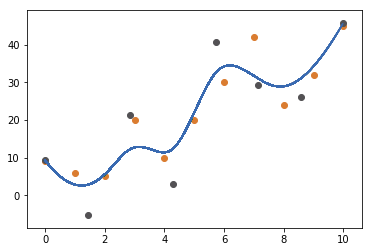

In [132]:
order = 4
control_points_size = 8
find_b_spline(order, control_points_size)

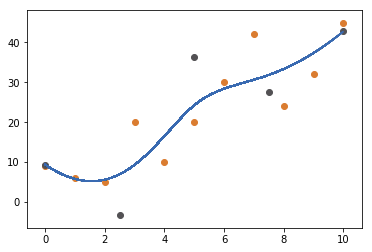

In [133]:
order = 4
control_points_size = 5
find_b_spline(order, control_points_size)

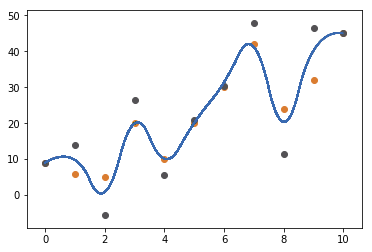

In [134]:
order = 3
control_points_size = 11
find_b_spline(order, control_points_size)

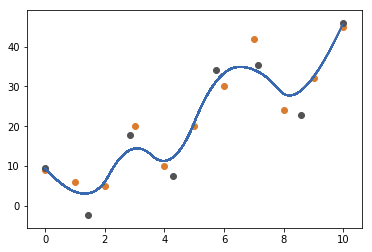

In [135]:
order = 3
control_points_size = 8
find_b_spline(order, control_points_size)

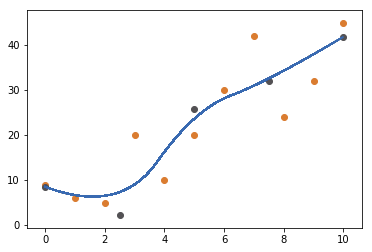

In [136]:
order = 3
control_points_size = 5
find_b_spline(order, control_points_size)